In [ ]:
from google.colab import files
uploaded = files.upload()

!mkdir -p /content/fruits360
!unzip -q "fruits-360_100x100.zip" -d /content/fruits360
!find /content/fruits360 -maxdepth 2 -type d -print

Saving fruits-360_100x100.zip to fruits-360_100x100 (1).zip
replace /content/fruits360/fruits-360/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/content/fruits360
/content/fruits360/fruits-360
/content/fruits360/fruits-360/Training
/content/fruits360/fruits-360/Test


In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Crear datasets
train_dir = "/content/fruits360/fruits-360/Training"
test_dir  = "/content/fruits360/fruits-360/Test"
img_size   = (224, 224)
batch_size = 64
seed       = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("N° clases:", num_classes)

train_ds = train_ds.take(200)
val_ds   = val_ds.take(50)

Found 117576 files belonging to 225 classes.
Using 94061 files for training.
Found 117576 files belonging to 225 classes.
Using 23515 files for validation.
Found 39212 files belonging to 225 classes.
N° clases: 225


In [ ]:
#preprocesamiento
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

def prep(ds, training=True):
    def _pp(images, labels):
        images = preprocess_input(images)
        return images, labels

    ds = ds.map(_pp)
    if training:
        ds = ds.shuffle(500)  # menos imágenes en RAM
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds_prep = prep(train_ds, training=True)
val_ds_prep   = prep(val_ds, training=False)
test_ds_prep  = prep(test_ds, training=False)


In [ ]:
#definir el modelo con MovileNetV3(transfer learning)
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, Model

base_model = MobileNetV3Small(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False   # congelamos pesos al inicio

inputs = keras.Input(shape=img_size + (3,))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 225)            │       129,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,945 (4.08 MB)

 Trainable params: 129,825 (507.13 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
#fase1
history_1 = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=5
)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - accuracy: 0.2323 - loss: 4.1777 - val_accuracy: 0.8453 - val_loss: 1.3967
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8413 - loss: 1.1713 - val_accuracy: 0.9287 - val_loss: 0.6754
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.9292 - loss: 0.6054 - val_accuracy: 0.9628 - val_loss: 0.4156
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9577 - loss: 0.3919 - val_accuracy: 0.9784 - val_loss: 0.2925
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9739 - loss: 0.2826 - val_accuracy: 0.9772 - val_loss: 0.2268


In [ ]:
# descongelamos algunas capas superiores
base_model.trainable = True

#afina las últimas N capas
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_2 = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=5
)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 50s 69ms/step - accuracy: 0.7264 - loss: 1.2512 - val_accuracy: 0.3237 - val_loss: 3.0291
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.9782 - loss: 0.1482 - val_accuracy: 0.4841 - val_loss: 2.1312
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.9880 - loss: 0.0778 - val_accuracy: 0.6466 - val_loss: 1.2323
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9937 - loss: 0.0504 - val_accuracy: 0.7937 - val_loss: 0.6474
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9964 - loss: 0.0337 - val_accuracy: 0.8884 - val_loss: 0.3300


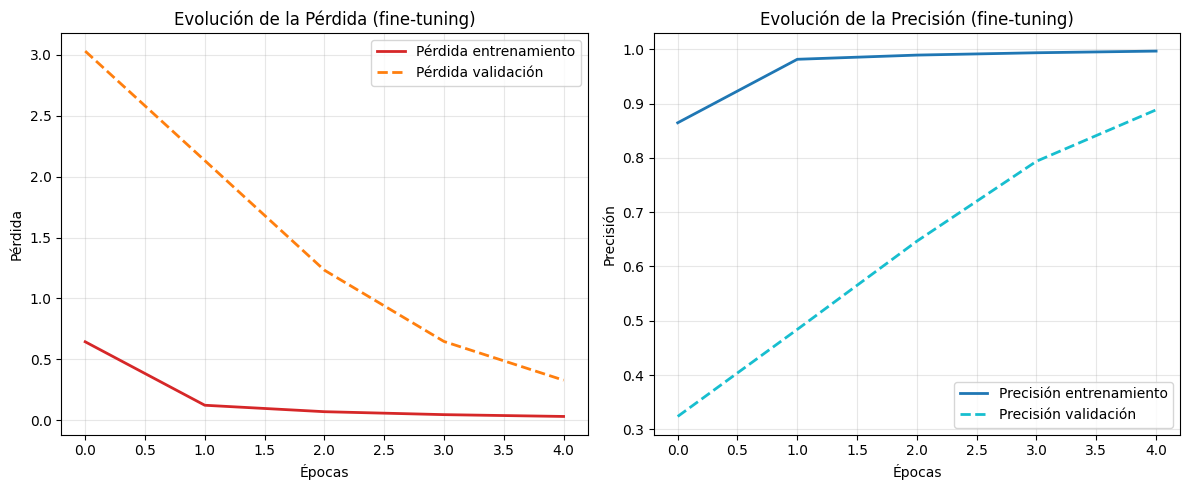

In [ ]:
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Pérdida entrenamiento', color='tab:red', linewidth=2)
plt.plot(history_2.history['val_loss'], label='Pérdida validación', color='tab:orange', linestyle='--', linewidth=2)
plt.title('Evolución de la Pérdida (fine-tuning)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(alpha=0.3)

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Precisión entrenamiento', color='tab:blue', linewidth=2)
plt.plot(history_2.history['val_accuracy'], label='Precisión validación', color='tab:cyan', linestyle='--', linewidth=2)
plt.title('Evolución de la Precisión (fine-tuning')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds_prep)
print(f"Accuracy en test (MobileNetV3): {test_acc*100:.2f}%")

613/613 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.8528 - loss: 0.4631
Accuracy en test (MobileNetV3): 84.81%


In [ ]:
# Obtener etiquetas verdaderas y predicciones
y_true = np.concatenate([y.numpy() for _, y in test_ds_prep])
y_prob = model.predict(test_ds_prep)
y_pred = np.argmax(y_prob, axis=1)
print(y_true)
print(y_pred)

613/613 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/step
[  0   0   0 ... 224 224 224]
[  0   0   0 ... 224 224 224]


In [ ]:
# Tomamos 1 batch de imágenes del conjunto de prueba
for images, labels in test_ds.take(1):
    # mismo preprocesamiento que en el entrenamiento
    images_pp = preprocess_input(images)
    probs = model.predict(images_pp, verbose=0)
    preds = np.argmax(probs, axis=1)

    images_np = images.numpy()
    labels_np = labels.numpy()
    break

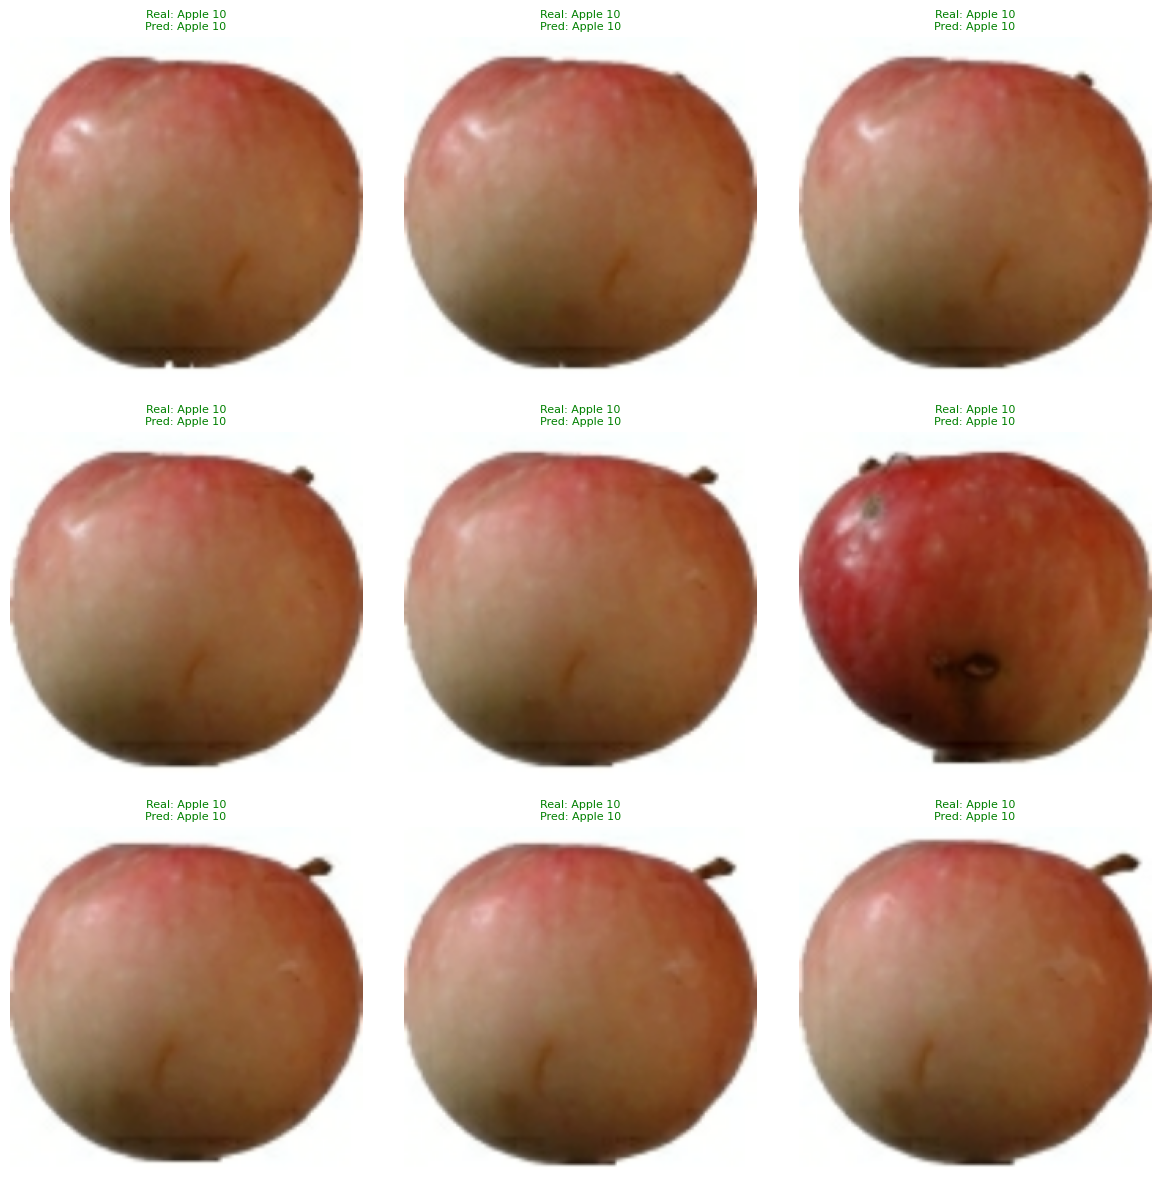

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(9):  # muestra 9 imágenes
    ax = plt.subplot(3, 3, i + 1)
    img = images_np[i] / 255.0  # normalizamos para mostrar

    true_label = class_names[labels_np[i]]
    pred_label = class_names[preds[i]]

    plt.imshow(img)
    plt.axis("off")

    color = "green" if labels_np[i] == preds[i] else "red"
    ax.set_title(f"Real: {true_label}\nPred: {pred_label}", color=color, fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Métricas de evaluación
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro    = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro        = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Accuracy:        {accuracy:.4f}")
print(f"Precision:       {precision_macro:.4f}")
print(f"Recall:          {recall_macro:.4f}")
print(f"F1 score:        {f1_macro:.4f}")

# Reporte de clasificación
print("\nReporte de clasificación (resumen):")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

Accuracy:        0.8481
Precision:       0.9096
Recall:          0.8543
F1 score:        0.8530

Reporte de clasificación (resumen):
                           precision    recall  f1-score   support

                 Apple 10       0.89      0.90      0.89       231
                 Apple 11       1.00      0.90      0.95       142
                 Apple 12       1.00      0.32      0.49       154
                 Apple 13       0.68      0.99      0.81       235
                 Apple 14       0.84      0.88      0.86       154
                 Apple 17       0.65      0.91      0.76       201
                 Apple 18       0.88      0.57      0.69       160
                 Apple 19       0.87      1.00      0.93       241
                  Apple 5       0.95      0.82      0.88       146
                  Apple 6       0.84      0.90      0.87       157
                  Apple 7       0.71      1.00      0.83       229
                  Apple 8       0.96      0.78      0.86      

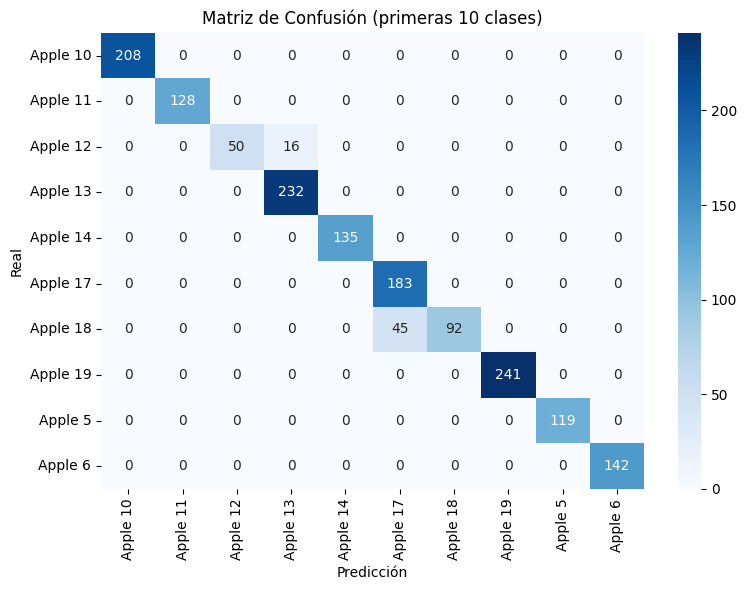

In [ ]:
#Matriz de confusión
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Seleccionar las primeras 10 clases
subset = 10
subset_names = class_names[:subset]

# Filtrar etiquetas y predicciones solo para esas clases
mask = (y_true < subset)
y_true_subset = y_true[mask]
y_pred_subset = y_pred[mask]

# Calcular la matriz de confusión solo para esas clases
cm = confusion_matrix(y_true_subset, y_pred_subset, labels=range(subset))

# Graficar con seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=subset_names, yticklabels=subset_names)
plt.title('Matriz de Confusión (primeras 10 clases)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()